Visualisation is undoubtably a tricky business. There are many questions to ask before even starting: What do I want to convey?  What tools do I have? Do I have the right data? This is even before considering whether your visualisation might have introduced a bias in some way. We will look at using Networkx and D3 to produce interactive network diagrams to display multiple layers of data. In this brief introduction we will render a simple graph, add some labels and colours and add some basic interaction.

<div id="d3-container-neighbours"></div>

After spending 5 minutes playing with the visualisation it is probably time to learn how it was made.

The [NetworkX package](https://networkx.github.io/) offers a great way to easily manipulate graph-like data. It is written purely in Python and is limited for large scale analysis of network data, but for moderate size networks can deliver a range of network statistics and metrics with little-to-no work.

[D3.js](http://d3js.org/) (Data Driven Documents) is a Javascript library which does *exactly what it says on the tin*, produces web-based content from data. D3.js is created by Mike Bostock and can do far more than just produce network diagrams. In fact I recommend just looking through the plethora of [examples](https://github.com/mbostock/d3/wiki/Gallery) of what can be done and get inspired. For now we'll look at the force-directed network layout.

We begin by importing the packages we need, namely the aforementioned Networkx, and the [json](https://docs.python.org/2/library/json.html) package which allows us to encode and decode JSON files. JSON, or JavaScript Object Notation, is commonly used for information transfer online such as streaming tweets from the Twitter API. The advantages of JSON are that is it human readable and easily to manipulate at a cost of being very inefficient in terms of storage. Finally we import the plotting functions of [matplotlib](http://matplotlib.org/) to draw our network.

In [1]:
import networkx as nx
import json
import matplotlib.pyplot as plt
%matplotlib inline

We'll generate a random Erdos-Reyni (ER) graph as a quick example, callable through the in-built Networkx function. ER graphs are generated by creating a set of $N$ nodes, and then for each potential node pairing, a coin is flipped and with probability $p$ and edge is formed. For small ER graphs it is likely (with probability $(1-p)^{(N-1)}$) that a node will have no edges which can be undesirable in some cases, hence we generate graphs untill we find one with a single connected component.

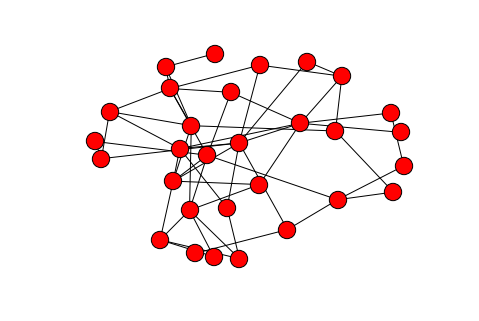

In [2]:
G = nx.erdos_renyi_graph(30,4.0/30)
while not nx.is_connected(G):
    G = nx.erdos_renyi_graph(30,4.0/30)
plt.figure(figsize=(6,4));
nx.draw(G)

The basic plotting functions of matplotlib are easy to use, and there a number of different layouts one can choose (circular, shell, random, spectral, e.t.c.). We can also add labels, colourings, and link weights, and, since we are in the realms of matplotlib, can even add standard plots to the figure such as a degree histogram. Networkx also supports output through the open source [Graphviz](http://www.graphviz.org/) however I have yet to explore its features and functions.

We'll use Networkx to work out two basic metrics, the degree of each node, and its degree parity (whether it's degree is even or odd). Degree parity is an important attribute for Eulerian walk problems such as the [Seven Bridges of Konigsberg](http://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg). We'll also calculate the Katz centrality of each node, just because we can!

In [3]:
for ix,deg in G.degree().items():
    G.node[ix]['degree'] = deg
    G.node[ix]['parity'] = (1-deg%2)

for ix,katz in nx.katz_centrality(G).items():
    G.node[ix]['katz'] = katz

G.nodes(data=True)[:5]

[(0, {'degree': 3, 'katz': 0.1658123856107354, 'parity': 0}),
 (1, {'degree': 2, 'katz': 0.15202714712288246, 'parity': 1}),
 (2, {'degree': 4, 'katz': 0.17512899102690338, 'parity': 1}),
 (3, {'degree': 6, 'katz': 0.22424042638359576, 'parity': 1}),
 (4, {'degree': 2, 'katz': 0.14564302217995662, 'parity': 1})]

As you can see, our nodes now have 3 attributes: the degree, the degree parity (1 for even, 0 for odd), and the katz centrality.

Once we've calculated everything that we might want from our network we can save it as JSON to use with D3 or to load into Networkx at a later time. Fortunately Networkx a tidy function to do this in *.node_link_data()*. When I first started making D3 graphs I ended up writing my own function to do this before discovering the Networkx built-in! We'll save the graph to our working directory as *graph.json*.

In [4]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(G)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

The output looks something like this:

```Javascript
{
    "nodes": [
        {
            "parity": 1, 
            "katz": 0.22874804284096154, 
            "id": 0, 
            "degree": 8
        }, 
        {
            "parity": 0, 
            "katz": 0.17413026830641998, 
            "id": 1, 
            "degree": 5
        }
    ],

    "links": [
        {
            "source": 0, 
            "target": 3
        }, 
        {
            "source": 0, 
            "target": 4
        }, 
        {
            "source": 0, 
            "target": 6
        },
    ]
}
```

That's basically all the Python done. From here we'll be working with HTML, CSS, and Javascript as well as the IPython magics which enable us to embed them in the notebook. For those unfamilar with web content design the key components can be described as follows:

* **HTML**: marks the content up into different structural types, like paragraphs, blocks, lists, images, tables, forms, comments e.t.c. 

* **CSS**: tells the browser how each type of element should be displayed, which may vary for different media (like screen, print or handheld device)

* **JavaScript**: tells the browser how to change the web page in response to events that happen (like clicking on something, or changing the value in a form input)

The code below does two things. It first creates a division (*div*) which we call *"d3-container"*. This essentially creates a box in which we can put our network diagram. The second statement obviously deals with the style of the network. Anything that we declare as a 'node' will have a white outline, and anything declared as a link will be grey. This statement by itself will not give any visible output yet - for that we need Javascript!

```html
<div id="d3-container">< /div>

<style>

.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}

< /style>
```

To create the visualisation we need to load in the D3 library from source, the data from our json file and then piece it all together. Javascript is, by no means the prettiest of languages to work with, so much so that there exists a sister language [CoffeeScript](http://coffeescript.org/) which is a direct 1-1 translation of Javascript. The code below looks quite daunting however it is fairly simple once the syntax is understood. Working with the D3 library, the main ideas are to 'select' the HTML elements, append further elements, and then set their attributes as required.

**Note**: There may be some issues with security when running this in a notebook. If the visualisation does not appear then look for a shield in the URL bar at the top of the browser and allow the script to be loaded (usually requires a page refresh). An alternative approach is to embed this HTML and Javascript into it's own HTML document and serve that to the browser using your favourite HTTP server. In practice, it is better to keep everything separate so that you would end up with a *index.html* file, a *style.css* file, and a *script.js* which are all joined through the HTML file.

<div id="d3-container-degree"></div>

``` javascript 
// We load the latest version of d3.js from the Web.
require.config({paths: {d3: "https://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
    
    // Parameter declaration, the height and width of our viz.
    var width = 300,
        height = 300;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width, height]);

    // We select the < div> we created earlier and add an <svg> container.
    // SVG = Scalable Vector Graphics
    var svg = d3.select("#d3-container").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-container").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }
        
    // We load the JSON network file.
    d3.json("graph.json", function(error, graph) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.
        
        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a < line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a < circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the degree.
                return color(d.degree); 
            })
            .call(force.drag);

        // The label each node its node number from the networkx graph.
        node.append("title")
            .text(function(d) { return d.id; });
        
        

        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});
```

All being well, once the above code has been run, the visualisation should appear just above it. This will colour all nodes according to their degreee. Admittedly, this is not the most enlightening visualisation and serves solely as an example of how the node attributes can be used. We will append two features two our visualisation; the ability to read the Katz centrality, and the ability to focus on individual nodes.

**Tooltips**

For a quick and easy tooltip we make the one line ammendment to our Javascript code. This will display the node ID, degree, and Katz centrality when we hover over the node.

```javascript

// The label each node its node number from the networkx graph.
node.append("title")
.text(function(d) { return "Node: " + d.id + "\n" + "Degree: " + d.degree + "\n" + "Katz: " + d.katz;});
    
```

**Node Highlighting**

Node highlighting is a more involved process. We first need to identify within the Javascript which nodes are connected to which. In truth, this can be outsourced to Networkx and then passed through to the Javascript through the JSON file with a little work. The following code should be added as the first thing after the graph is loaded. This allows us to double click on a node to highlight its immediate neighbourhood which could be useful if the network is crowded or a node's neighbourhood is of particular importance in the data.

```javascript

//Toggle stores whether the highlighting is on
var toggle = 0;

//Create an array logging what is connected to what
var linkedByIndex = {};

for (var i = 0; i < graph.nodes.length; i++) {
    linkedByIndex[i + "," + i] = 1;
};

graph.links.forEach(function (d) {
    linkedByIndex[d.source.index + "," + d.target.index] = 1;
});

//Looks up whether a pair of nodes are neighbours.
function neighboring(a, b) {
    return linkedByIndex[a.index + "," + b.index];
}

function connectedNodes() {
    if (toggle == 0) {
        //Reduce the opacity of all but the neighbouring nodes to 0.3.
        var d = d3.select(this).node().__data__;
        node.style("opacity", function (o) {
            return neighboring(d, o) | neighboring(o, d) ? 1 : 0.3;
        });
        //Reduce the opacity of all but the neighbouring edges to 0.8.
        link.style("opacity", function (o) {
            return d.index==o.source.index | d.index==o.target.index ? 1 : 0.8;
        });
        //Increases the stroke width of the neighbouring edges.
        link.style("stroke-width", function (o) {
            return d.index==o.source.index | d.index==o.target.index ? 3 : 0.8;
        });
        //Reset the toggle.
        toggle = 1;
    } else {
        //Restore everything back to normal
        node.style("opacity", 1);
        link.style("opacity", 1);
        link.style("stroke-width", 1);
        toggle = 0;
    }
} 

```

and then finally append this to our nodes:

```javascript

.on('dblclick', connectedNodes);

```

This produces the following graph (which featured at the head of the article also). One can definitely argue that it is more informative than the original matplotlib and our first attempt at a D3 visualisation. 

<div id="d3-container-neighbours"></div>

Discussion
---

D3 is a powerful library which can produce exciting and interactive documents/visualisations. I hope I have provided enough content to at least spark interest, and enough links to other content to be helpful. This is indeed a very introductory example of the power of D3 but highlights how interactivity can make even random data interesting. I will hopefully have the time after the holidays to produce some more  in-depth work which should appeal to a wider audience. Currently D3 requires working knowledge of Javascript and general web-based tricks and conventions, which arguably do not feature in the skill set of many data scientists. This is a shame as it offers new ways to communicate science to both academia and to the general public. One approach is to use CoffeeScript. This has a Pythonic syntax and would make the transition slightly smoother, however this does require a some work in preprocessing and it is also not natively supported. You *can* translate CoffeeScript in the browser although the creator has actively expressed that this is not a good idea.

It is my belief that in the near future, as we move away from printed material, all figures will have some degree of interactivity. This can be as subtle as a simple labeling on a line plot, the ability to alter parameters in a model, or going all the way and producing a user-driven dynamic which gives the end result. There is also scope for adaptability and automation of data retrieval and data analysis. For those involved with open data, the workflow is usually of the form; data retrieval through an API, data processing, and data visualisation. The web framework allows this workflow to happen in real-time (or near real-time) giving a useful insight into how the data is evolving, and also giving an opportunity to give reactive outputs. Naturally one should take the same level of care as one does with a static visualisation and not add interactivity purely for interactivities' sake. The main questions still stand; does my visualisation convey what it is supposed to and does it convey the message *clearly*?

A few other links of interest are listed below:

* [ipyD3](http://nbviewer.ipython.org/gist/z-m-k/4484816/ipyD3sample.ipynb): A Python package which incorporates static D3 into the IPython notebook.
* [Curved Edges](http://bl.ocks.org/mbostock/1153292): Creating curved and styled edges with D3. This has been the basis for some of my visualisation of Twitter networks.
* [An A to Z of Extra Features for the D3 Force Layout](http://www.coppelia.io/an-a-to-z-of-extra-features-for-the-d3-force-layout/): A few extensions of the above code to add interactivity.
* [How to Make an Interactive Network Visualization](http://flowingdata.com/2012/08/02/how-to-make-an-interactive-network-visualization/): More interactivity.

<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
div#d3-container-neighbours { margin-left: auto; margin-right: auto; position: relative;}
div#d3-container-degree { margin-left: auto; margin-right: auto; position: relative;}
</style>

<script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>

<script>
    // Parameter declaration, the height and width of our viz.
    var width2 = 600,
        height2 = 250;

    // Colour scale for node colours.
    var color2 = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force2 = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width2, height2]);

    // We select the <div> we created earlier and add an <svg> container.
    // SVG = Scalable Vector Graphics
    var svg2 = d3.select("#d3-container-degree").select("svg")
    if (svg2.empty()) {
        svg2 = d3.select("#d3-container-degree").append("svg")
                    .attr("width", width2)
                    .attr("height", height2);
    }
        
    // We load the JSON network file.
    d3.json("./graph.json", function(error, graph2) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.
        
        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force2.nodes(graph2.nodes)
            .links(graph2.links)
            .start();

        // We create a <line> SVG element for each link
        // in the graph.
        var link2 = svg2.selectAll(".link")
            .data(graph2.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a <circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node2 = svg2.selectAll(".node")
            .data(graph2.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the degree.
                return color2(d.degree); 
            })
            .call(force2.drag);

        // The label each node its node number from the networkx graph.
        node2.append("title")
            .text(function(d) { return d.id; });
        
        

        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force2.on("tick", function() {
            link2.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node2.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
</script>

<script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>
     
<script>
    // Parameter declaration, the height and width of our viz.
    var width = 600,
        height = 250;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(30)
        .size([width, height]);

    // We select the <div> we created earlier and add an <svg> container.
    // SVG = Scalable Vector Graphics
    var svg = d3.selectAll("#d3-container-neighbours").select("svg")
    if (svg.empty()) {
        svg = d3.selectAll("#d3-container-neighbours").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }
    
    // We load the JSON network file.
    d3.json("./graph.json", function(error, graph) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.
        
        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a <line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        //Toggle stores whether the highlighting is on
        var toggle = 0;
        //Create an array logging what is connected to what
        var linkedByIndex = {};

        for (var i = 0; i < graph.nodes.length; i++) {
            linkedByIndex[i + "," + i] = 1;
        };

        graph.links.forEach(function (d) {
            linkedByIndex[d.source.index + "," + d.target.index] = 1;
        });

        //This function looks up whether a pair are neighbours
        function neighboring(a, b) {
            return linkedByIndex[a.index + "," + b.index];
        }

        function connectedNodes() {
            if (toggle == 0) {
                //Reduce the opacity of all but the neighbouring nodes
                var d = d3.select(this).node().__data__;
                node.style("opacity", function (o) {
                    return neighboring(d, o) | neighboring(o, d) ? 1 : 0.3;
                });
                link.style("opacity", function (o) {
                    return d.index==o.source.index | d.index==o.target.index ? 1 : 0.8;
                });
                link.style("stroke-width", function (o) {
                    return d.index==o.source.index | d.index==o.target.index ? 3 : 0.8;
                });
                //Reduce the op
                toggle = 1;
            } else {
                //Put them back to opacity=1
                node.style("opacity", 1);
                link.style("opacity", 1);
                link.style("stroke-width", 1);
                toggle = 0;
            }
        }    
        
        // We create a <circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the degree.
                return color(d.parity); 
            })
            .call(force.drag)
            .on('dblclick', connectedNodes);

        // The label each node its node number from the networkx graph.
        node.append("title")
        .text(function(d) { return "Node: " + d.id + "\n" + "Degree: " + d.degree + "\n" + "Katz: " + d.katz;});
        
        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });        
            
        });
    });
</script>

[]({attach}/data/graph.json)